In [122]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.1 MB/s eta 0:00:005.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Problem to Analyze
##  How would you build a scorecard system?

1. Clarify
---
In order to define the approach to be taken in a better way, first I would like to ask some questions about the scenario. 

What would be the purpose of the scorecards, would it be use to incentivize usage, to try to minize the default rate of the clients or to mantain client loyalty?


2. Constrain
---
I would also like to know if we have categorical binary label or if there is already a scorecard system in operation with defined buckets.

Also, one important question to define the approach is if there is any defined target for the loss and coverage that we need to guarantee.

3. Plan
---
The approach that I would like to take, given that there are no set labels or scorecard groups is to use the data we have with some potential key characteristic of the client group, those being:

    - age
    - marriage 
    - if he or she has kids
    - salary
    - properties owned
    - amount of monthly bills to pay
    - scholarity
    - job field
    - how many years has he or she been working in his current job
    - Amount of credit requested
    - Loan duration
    
4. Method
---

Given that we have historical data with client and billing information as well as a define label that classifies the clients as defaulting or not.

What I would do is use a classifier model, we could use K-means algorithm or hierarchical classification or try to implement a random forest classifier. As well as trying to implement a neural network being wary of possible overfitting. 

In order to prepare the data first I would clean it, then to evaluate the features, I see that we have some columns such as age that will work better if we create age buckets with our neural network. After bucketing, standardizing and normalizing the data I would perform feature engineering to evaluate the importance of those variables as well.

5. Conclude
---

# Import Dependencies

In [125]:
# Import Dependencies for Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Dependencies for visualization
import seaborn as sns

# Import Dependencies for the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Import Dependencies for sampling the data
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

## Define Functions

In [62]:
# Remove Outliers
def remove_outliers(data, columns, z_threshold=3):
    """
    Remove outliers from specific columns of a DataFrame using the z-score method.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to remove outliers from.
        z_threshold (float): The z-score threshold for identifying outliers. Default is 3.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed from the specified columns.
    """
    data_cleaned = data.copy()

    for column in columns:
        z_scores = np.abs((data_cleaned[column] - data_cleaned[column].mean()) / data_cleaned[column].std())
        outliers = data_cleaned[z_scores > z_threshold]

        data_cleaned = data_cleaned.drop(outliers.index)

    return data_cleaned

In [63]:
# Sampling Technique 
def perform_sampling(X, y, method):
    if method == 'undersampling':
        sampler = RandomUnderSampler()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'oversampling':
        sampler = RandomOverSampler()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'combination':
        sampler = SMOTEENN()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'smote':
        sampler = SMOTE()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'cluster_centroids':
        sampler = ClusterCentroids()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    else:
        raise ValueError("Invalid sampling technique specified.")

    return X_resampled, y_resampled

In [64]:
# Determine the number of bins
def determine_num_bins(data, method='sqrt'):
    """
    Determine the number of bins for multiple columns in a DataFrame using the square root rule, Sturges' formula, or the Freedman-Diaconis rule.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        method (str): The method to use for determining the number of bins. Possible values: 'sqrt', 'sturges', 'freedman-diaconis'.

    Returns:
        dict: A dictionary mapping column names to the number of bins determined by the specified method.
    """
    num_bins_dict = {}

    for column in data.columns:
        column_data = data[column]

        if method == 'sqrt':
            num_bins = int(np.sqrt(len(column_data)))
        elif method == 'sturges':
            num_bins = int(np.ceil(np.log2(len(column_data)) + 1))
        elif method == 'freedman-diaconis':
            unique_values = len(column_data.unique())
            iqr = np.percentile(column_data, 75) - np.percentile(column_data, 25)

            # Check if the IQR is zero or the number of unique values is less than or equal to 1
            if iqr == 0 or unique_values <= 1:
                num_bins = 1  # Set the number of bins to 1
            else:
                bin_width = 2 * iqr / np.power(unique_values, 1/3)
                num_bins = int(np.ceil((column_data.max() - column_data.min()) / bin_width))
        else:
            raise ValueError("Invalid method specified. Supported methods: 'sqrt', 'sturges', 'freedman-diaconis'.")

        num_bins_dict[column] = num_bins

    return num_bins_dict

In [65]:
# Equal Frequency feature binning
def equal_frequency_binning(data, features, num_bins_dict):
    """
    Perform equal frequency binning on numerical features in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        features (list): A list of column names to be binned.
        num_bins_dict (dict): A dictionary mapping column names to the desired number of bins.

    Returns:
        pd.DataFrame: The DataFrame with the binned features and dropped original columns.
    """
    data_binned = data.copy()

    for feature in features:
        num_bins = num_bins_dict.get(feature, 1)

        bin_size = len(data_binned) // num_bins

        data_binned.sort_values(by=feature, inplace=True)

        data_binned[feature + '_bin'] = pd.qcut(data_binned[feature], q=num_bins, labels=False, duplicates='drop')

        data_binned.drop(columns=feature, inplace=True)

    return data_binned

In [76]:
# Perform PCA
def perform_pca(X, explained_variance_threshold=0.95):
    """
    Perform PCA on the input data and determine the number of components to keep based on the explained variance threshold.

    Args:
        X (numpy.ndarray or pandas.DataFrame): The input features for PCA.
        explained_variance_threshold (float): The desired cumulative explained variance threshold.
                                              Default is 0.95, indicating to retain components that explain at least 95% of the variance.

    Returns:
        pandas.DataFrame: The transformed data after PCA is applied with proper column names.
        int: The optimal number of components to retain.

    """
    # Initialize PCA
    pca = PCA()

    # Fit PCA on the features
    pca.fit(X)

    # Calculate cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of components that meet the explained variance threshold
    num_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1

    # Perform PCA with the determined number of components
    pca = PCA(n_components=num_components)
    transformed_data = pca.fit_transform(X)

    # Create column names for the transformed features
    column_names = [f"PC_{i+1}" for i in range(num_components)]

    # Create a DataFrame with the transformed features and column names
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)

    return transformed_df, num_components

# Data Exploration

In [2]:
# Declare file path variable
file_path = 'resources/UCI_Credit_Card.csv'

# Read data
credit_df = pd.read_csv(file_path)
credit_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Dataset Shape

In [3]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

By analyzing our dataset shape we can see that we have one categorical value that will be our label, default.payment.next.month. The columns we have to work with can be divided into the following categories:
- Client Information
    - ID
    - SEX
    - EDUCATION
    - MARRIAGE
    - AGE
- Billing Information
    - Balance Limit
    - Amount of bill statement
    - Amount of previous payment
    - Repayment
- Default Label
    - default.payment.next.month
    
We also see that we don't have any missing data on any of our columns

In [23]:
credit_df.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              56
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default.payment.next.month        2
dtype: int64

In [66]:
# Drop the ID column
credit_df.drop('ID', axis=1, inplace=True)

<AxesSubplot:ylabel='default.payment.next.month'>

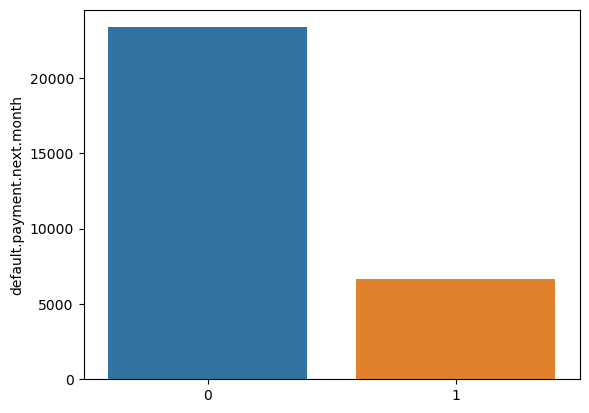

In [10]:
# Plot the proportion of both labels
sns.barplot(x= credit_df["default.payment.next.month"].value_counts().index
           ,y= credit_df["default.payment.next.month"].value_counts())

In [17]:
proportion_true=str(round(sum(credit_df['default.payment.next.month'] == True) / len(credit_df['default.payment.next.month']), 2) * 100)
proportion_false=str(round(sum(credit_df['default.payment.next.month'] == False) / len(credit_df['default.payment.next.month']), 3) * 100)

print(f'Default Label: {proportion_true} %')
print(f'Not Default Label: {proportion_false} %')

Default Label: 22.0 %
Not Default Label: 77.9 %


As the plot suggest, and as we would normally expect from a credit related data, we are dealing with an imbalanced target label, we can evaluate and use techniques of either:
- Oversampling the Default Label
    - The main issue to consider with oversampling is the possibility of overfitting the model.
- Undersampling the Not Default Label
    - The tradeoff of opting for undersampling would be a potential loss of classification performance.
- Combination of undersampling and oversampling
    - The concept is that we can apply a modest amount of oversampling to the minority class, which improves the bias to the minority class examples, whilst we also perform a modest amount of undersampling on the majority class to reduce the bias on the majority class examples.
- SMOTE oversampling
    - In SMOTE, new instances of the minority are interpolated. The drawbacks are the possibility of creating outliers.
- Cluster Centroids Undersampling
    - It identifies clusters of the majority class and generates synthetic datapoints then undersamples the majority class. Disadvantages of this method are an increased bias

## Remove Outliers

In [58]:
# Define columns
column_outliers = ['ID', 'LIMIT_BAL','PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Use function to remove outliers
df_clean = remove_outliers(credit_df, column_outliers,z_threshold= 3)
df_clean.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,...,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000,23651.000000
mean,14926.493383,145357.574733,1.610756,1.866686,1.556594,35.265443,-0.053148,-0.189041,-0.230265,-0.302059,...,25129.628219,22872.829310,21787.131411,3055.774640,2941.832142,2565.274788,2251.762674,2251.471397,2383.429707,0.227094
std,8658.808004,116388.443988,0.487589,0.781787,0.523729,9.316914,1.070579,1.158475,1.152293,1.105131,...,30113.359536,28149.813509,27641.704155,4238.208116,4192.641013,3920.784687,3532.614573,3452.436323,4226.652130,0.418963
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-46627.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7423.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1261.000000,894.000000,626.500000,640.000000,486.000000,279.000000,80.500000,3.500000,0.000000,0.000000
50%,14891.000000,110000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,14691.000000,12580.000000,10614.000000,2000.000000,1850.000000,1457.000000,1039.000000,1064.000000,1000.000000,0.000000
75%,22372.500000,210000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,37643.500000,31194.500000,30067.500000,3700.000000,3500.000000,3000.000000,2910.500000,3000.000000,2937.500000,0.000000
max,30000.000000,550000.000000,2.000000,6.000000,3.000000,75.000000,3.000000,3.000000,3.000000,3.000000,...,153551.000000,132948.000000,120398.000000,36396.000000,35157.000000,31200.000000,28800.000000,27106.000000,39544.000000,1.000000


# Feature Engineering

## Feature Binning

In [54]:
# Determine the number of bins
num_bins_dict = determine_num_bins(credit_df, method='freedman-diaconis')
num_bins_dict

{'ID': 32,
 'LIMIT_BAL': 12,
 'SEX': 1,
 'EDUCATION': 6,
 'MARRIAGE': 3,
 'AGE': 9,
 'PAY_0': 12,
 'PAY_2': 12,
 'PAY_3': 12,
 'PAY_4': 12,
 'PAY_5': 11,
 'PAY_6': 11,
 'BILL_AMT1': 252,
 'BILL_AMT2': 244,
 'BILL_AMT3': 444,
 'BILL_AMT4': 284,
 'BILL_AMT5': 288,
 'BILL_AMT6': 373,
 'PAY_AMT1': 2176,
 'PAY_AMT2': 4025,
 'PAY_AMT3': 2133,
 'PAY_AMT4': 1594,
 'PAY_AMT5': 1075,
 'PAY_AMT6': 1299,
 'default.payment.next.month': 1}

In [52]:
# Perform feature binning using equal frequency binning
features_to_bin = ['AGE','EDUCATION','LIMIT_BAL'
                   ,'PAY_0','PAY_2','PAY_3'
                   ,'PAY_4','PAY_5','PAY_6']
df_binned = equal_frequency_binning(credit_df,features_to_bin,num_bins_dict)

## Oversample

In [67]:
# Define X and y for your features and target variable
X = df_binned.drop('default.payment.next.month', axis = 1)
y = df_binned['default.payment.next.month']

In [69]:
# Oversample the data using SMOTE
X_resampled,y_resampled = perform_sampling(X,y,'smote')

## Scale and Normalize the features

In [97]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Apply the scaler to the training and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Perform PCA

In [112]:
# Perform PCA and get transformed features and num_components
X_train_transformedd, num_components = perform_pca(X_train_scaled)
X_test_transformed, num_components = perform_pca(X_test_scaled)

# Logistic Regression

In [113]:
# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the transformed features
model.fit(transformed_df, y_train)

# Make predictions on the transformed test features
predictions = model.predict(X_test_transformed)

# Evaluate the model on the scaled test data
accuracy = model.score(X_test_transformed, y_test)
accuracy

0.7942222222222223

## Classfication Report

In [114]:
# Calculate classification report
report = classification_report(y_test, predictions, output_dict=True)

# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()

# Print the DataFrame
print(df_report)

              precision    recall  f1-score      support
0              0.805579  0.970525  0.880393  7023.000000
1              0.615955  0.167931  0.263911  1977.000000
accuracy       0.794222  0.794222  0.794222     0.794222
macro avg      0.710767  0.569228  0.572152  9000.000000
weighted avg   0.763925  0.794222  0.744972  9000.000000


## Confusion Matrix

In [115]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Print the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,6816,207
Actual Positive,1645,332


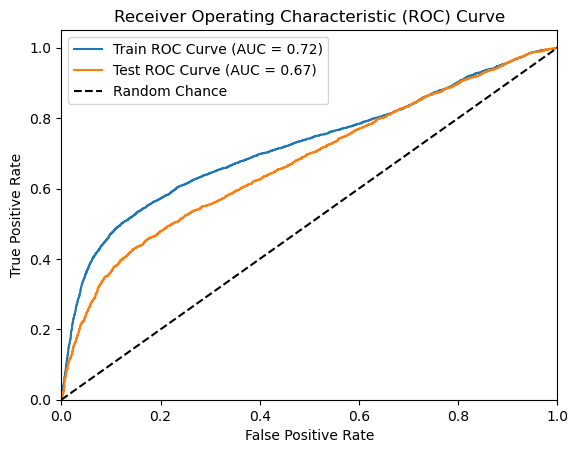

In [116]:
# Calculate the probabilities for the positive class
train_probs = model.predict_proba(X_train_transformed)[:, 1]
test_probs = model.predict_proba(X_test_transformed)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_probs)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_probs)

# Calculate the AUC scores
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train ROC Curve (AUC = {:.2f})'.format(train_auc))
plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_auc))

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Set the x-axis and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Display the plot
plt.show()

# Random Forest

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# XGBoost

In [126]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees (you can adjust this)
    max_depth=3,  # Maximum tree depth (you can adjust this)
    learning_rate=0.1,  # Learning rate (you can adjust this)
    random_state=42  # Set a random seed for reproducibility
)

In [127]:
xgb_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [128]:
y_pred = xgb_model.predict(X_test_transformed)

In [129]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7985555555555556


In [130]:
y_pred_proba = xgb_model.predict_proba(X_test_transformed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.720360934168828
